In [1]:
# importing relevant packages 

import torch 
from torchvision import models
import pandas as pd
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import glob
import os
import cv2
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms
from torchsummary import summary
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import json

/home/dell/Desktop/xxxx/Uni/Kirigami_project/Keypoint_detection_notebooks/.Keypoint_detection_notebooks/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
header = ['image_name', 'left_eye_x', 'left_eye_y', 'right_eye_x', 'right_eye_y', 'nose_x', 'nose_y']
image_data = []
image_name_arr = []
left_eye_x_arr = []
left_eye_y_arr = []
right_eye_x_arr = []
right_eye_y_arr = []
nose_x_arr = []
nose_y_arr = []

with open('./Cat_dataset/Cat_labels.json', 'r') as f:
    images = json.load(f)
    
    for image in images:
        
        image_name_arr.append(image['data']['img'][-6:]) # image_name
        left_eye_x_arr.append(image['annotations'][0]['result'][0]['value']['x']/100) # left_eye_x
        left_eye_y_arr.append(image['annotations'][0]['result'][0]['value']['y']/100) # left_eye_y
        right_eye_x_arr.append(image['annotations'][0]['result'][1]['value']['x']/100) # right_eye_x
        right_eye_y_arr.append(image['annotations'][0]['result'][1]['value']['y']/100) # right_eye_y
        nose_x_arr.append(image['annotations'][0]['result'][2]['value']['x']/100) # nose_x
        nose_y_arr.append(image['annotations'][0]['result'][2]['value']['y']/100) # nose_y
        
        
        
#         print(image['data']['img'][-6:]) # Image name
#         print(image['annotations'][0]['result'][0]['value']['x']) # left_eye_x
#         print(image['annotations'][0]['result'][0]['value']['y']) # left_eye_y
#         print(image['annotations'][0]['result'][1]['value']['x']) # right_eye_x
#         print(image['annotations'][0]['result'][1]['value']['y']) # right_eye_y
#         print(image['annotations'][0]['result'][2]['value']['x']) # nose_x
#         print(image['annotations'][0]['result'][2]['value']['y']) # nose_y
        

image_data = pd.concat([pd.Series(image_name_arr),pd.Series(left_eye_x_arr),pd.Series(left_eye_y_arr),pd.Series(right_eye_x_arr),pd.Series(right_eye_y_arr),pd.Series(nose_x_arr),pd.Series(nose_y_arr)], axis=1, keys=header)
print(image_data.shape)



(50, 7)


In [4]:
current_dir = os. getcwd()
images_dir = os.path.join(current_dir, 'Cat_dataset')

In [5]:
image_data.iloc[0]['image_name']

'00.jpg'

In [6]:
img_arr = cv2.imread(os.path.join(images_dir, image_data.iloc[0]['image_name']))

In [7]:
img_arr.shape

(350, 400, 3)

In [8]:
img = cv2.resize(img_arr, (224,224))
img_tensor = transforms.ToTensor()(img)
print(img_tensor.shape)
img_mean = img_tensor.mean(dim = (1,2))
img_std = img_tensor.std(dim = (1,2))

torch.Size([3, 224, 224])


NameError: name 'x_width' is not defined

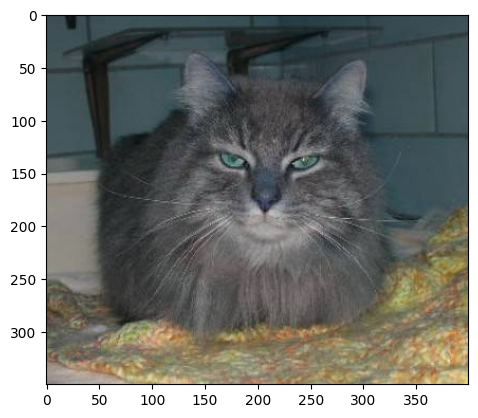

In [9]:
plt.imshow(img_arr)
x_points = image_data.iloc[0][1:][::2]
y_points = image_data.iloc[0][2:][::2]
width = img_arr.shape[0]
height = img_arr.shape[1]

plt.scatter(x_points*x_width, y_points*y_height)

In [100]:
class CatDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df
        self.img_dir = img_dir
        
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        image = cv2.imread(img_path)
        label = self.df.iloc[idx, 1:]
        image = self.transform_image(image)
        return image.to(device), torch.tensor(label).to(device)
    
    def __len__(self):
        return self.df.shape[0]
    
    def transform_image(self, img):
        img = cv2.resize(img, (224,224))
        img_tensor = transforms.ToTensor()(img)
        img_mean = img_tensor.mean(dim = (1,2))
        img_std = img_tensor.std(dim = (1,2))
        
        img_normalised = transforms.Normalize(img_mean, img_std)(img_tensor)
        return img_normalised
    
    def load_img(self, idx):
        img_path = os.path.join(self.img_dir, self.df.iloc[idx, 0])
        img = cv2.imread(img_path)
        return img
    

In [101]:
current_dir = os. getcwd()
images_dir = os.path.join(current_dir, 'Cat_dataset')
print(images_dir)

/home/dell/Desktop/xxxx/Uni/Kirigami_project/Keypoint_detection_notebooks/Cat_dataset


In [102]:
train_df, test_df = train_test_split(image_data, test_size=0.04)

In [103]:
print(train_df.shape)
print(test_df.shape)

(48, 7)
(2, 7)


In [104]:
train_dataset = CatDataset(train_df, images_dir)
test_dataset = CatDataset(test_df, images_dir)

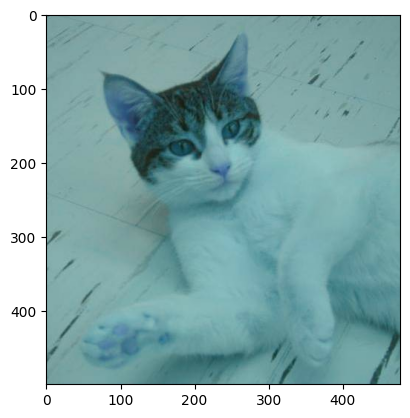

In [105]:
img = test_dataset.load_img(0)
plt.imshow(img)

In [65]:
img_tensor, labels = train_dataset[0]

In [66]:
labels

tensor([0.5807, 0.2595, 0.7217, 0.2754, 0.6605, 0.3553], device='cuda:0',
       dtype=torch.float64)

In [67]:
img_tensor

tensor([[[-1.4794, -1.0794, -1.6179,  ..., -1.4179, -1.2948, -1.3717],
         [-1.4794, -1.0332, -1.6025,  ..., -1.5564, -1.2794, -1.3563],
         [-1.4948, -0.9717, -1.5871,  ..., -1.5102, -1.2794, -1.3409],
         ...,
         [ 0.1670,  0.1208,  0.1362,  ..., -1.5871, -1.4794, -1.5564],
         [ 0.0901,  0.1516,  0.2439,  ..., -1.5718, -1.4640, -1.5718],
         [ 0.1054,  0.1516,  0.1824,  ..., -1.5871, -1.5410, -1.5871]],

        [[-1.4646, -1.0191, -1.6359,  ..., -1.4475, -1.2419, -1.2761],
         [-1.4646, -0.9677, -1.6188,  ..., -1.6017, -1.2247, -1.2761],
         [-1.4817, -0.8992, -1.6017,  ..., -1.5503, -1.2247, -1.2590],
         ...,
         [-0.4195, -0.4709, -0.4709,  ..., -1.7387, -1.5674, -1.6531],
         [-0.5051, -0.4366, -0.3338,  ..., -1.7559, -1.5845, -1.6702],
         [-0.4537, -0.4023, -0.3509,  ..., -1.7559, -1.6359, -1.6873]],

        [[-1.3963, -0.9780, -1.5572,  ..., -1.3963, -1.1228, -1.1550],
         [-1.3963, -0.9298, -1.5411,  ..., -1

In [69]:
img_np = img_tensor.cpu().numpy()
img_np

array([[[-1.4794308 , -1.0793666 , -1.6179146 , ..., -1.4178824 ,
         -1.2947857 , -1.3717213 ],
        [-1.4794308 , -1.0332053 , -1.6025275 , ..., -1.5563662 ,
         -1.2793987 , -1.3563341 ],
        [-1.4948179 , -0.971657  , -1.5871404 , ..., -1.5102049 ,
         -1.2793987 , -1.340947  ],
        ...,
        [ 0.16698727,  0.12082601,  0.1362131 , ..., -1.5871404 ,
         -1.4794308 , -1.5563662 ],
        [ 0.09005184,  0.15160018,  0.24392268, ..., -1.5717533 ,
         -1.4640437 , -1.5717533 ],
        [ 0.10543893,  0.15160018,  0.18237434, ..., -1.5871404 ,
         -1.5409791 , -1.5871404 ]],

       [[-1.4646163 , -1.0191498 , -1.6359496 , ..., -1.447483  ,
         -1.241883  , -1.2761497 ],
        [-1.4646163 , -0.9677498 , -1.6188163 , ..., -1.6016829 ,
         -1.2247496 , -1.2761497 ],
        [-1.4817497 , -0.8992165 , -1.6016829 , ..., -1.550283  ,
         -1.2247496 , -1.2590164 ],
        ...,
        [-0.4194833 , -0.47088328, -0.47088328, ..., -

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(3, 224, 224)
(224, 224, 3)


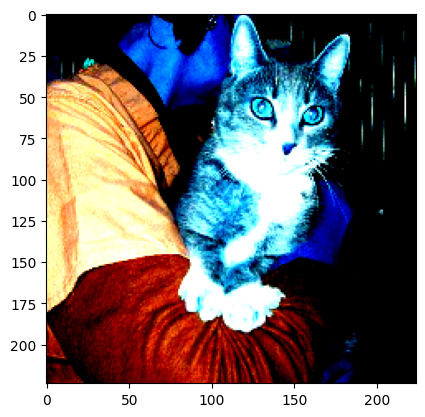

In [343]:
print(img_np.shape)
img_np_reverted = np.transpose(img_np, (1,2,0))
print(img_np_reverted.shape)
plt.imshow(img_np_reverted, clim=(-1, 1))

In [344]:
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2, shuffle=True)

In [345]:
for img, points in train_dataloader:
  print(img.shape)
  print(points.shape)
  break

torch.Size([8, 3, 224, 224])
torch.Size([8, 6])


In [346]:
# class VGG_model(nn.Module):
#     def __init__(self):
#         super(VGG_model, self).__init__()
#         self.features = nn.Sequential(
#             nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
#             nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
#             nn.Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
#             nn.Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
#             nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
#         )
        
#         self.avgpool = nn.Sequential(
#             nn.Conv2d(512,512, kernel_size=3, padding='same'),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(512,50, kernel_size=3, padding='same'),
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.AdaptiveAvgPool2d(output_size=(8,8))
#         )
        
#         self.classifier = nn.Sequential(
#             nn.Linear(3200, 300),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(300, 6),
#             nn.Sigmoid()
#         )
    
#     def forward(self, x):
#         x = self.features(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0), -1)
#         x = self.classifier(x)
#         return x
        

In [347]:
model = models.vgg16(pretrained=True)

In [348]:
# making the weights non trainable

for param in model.parameters():
  param.requires_grad = False

In [349]:
from torch.nn.modules.activation import Sigmoid
from torch.nn.modules.pooling import AdaptiveAvgPool2d
pool_layer = nn.Sequential(
     nn.Conv2d(512,512, kernel_size=3, padding='same'),
     nn.ReLU(),
     nn.MaxPool2d(kernel_size=2, stride=2),
     nn.Conv2d(512,50, kernel_size=3, padding='same'),
     nn.ReLU(),
     nn.MaxPool2d(kernel_size=2, stride=2),
     nn.AdaptiveAvgPool2d(output_size=(8,8))
)

model.avgpool = pool_layer

final_predictor = nn.Sequential(
    nn.Linear(3200, 300),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(300, 6),
    nn.Sigmoid()
)

model.classifier = final_predictor

In [350]:
summary(model, torch.rand(1,3,224,224))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-3                       [-1, 64, 224, 224]        (36,928)
|    └─ReLU: 2-4                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-5                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-6                       [-1, 128, 112, 112]       (73,856)
|    └─ReLU: 2-7                         [-1, 128, 112, 112]       --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (147,584)
|    └─ReLU: 2-9                         [-1, 128, 112, 112]       --
|    └─MaxPool2d: 2-10                   [-1, 128, 56, 56]         --
|    └─Conv2d: 2-11                      [-1, 256, 56, 56]         (295,168)
|    └─ReLU: 2-12                        [-1, 256, 56,

In [351]:
# getting the optimizer and loss_function 

def get_essentials():
  loss_fun = nn.L1Loss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
  return loss_fun, optimizer

In [352]:
# defining batch_train and accuracy functions


def train_batch(data, model, loss_fun, optimizer):
  model.train()
  img, true_points = data
  pred_points = model(img)
  loss_val = loss_fun(pred_points, true_points)
  loss_val.backward()
  optimizer.step()
  optimizer.zero_grad()
  return loss_val.item()

@torch.no_grad()
def val_batch(data, model, loss_fun, optimizer):
  model.eval()
  img, true_points = data
  pred_points = model(img)
  loss_val = loss_fun(pred_points, true_points)
  return loss_val.item()


In [353]:
epochs = 100
loss_fun, optimizer = get_essentials()

In [354]:
# training and validation loops 


train_epoch, val_epoch = [], []
for epoch in tqdm(range(epochs)):
  train_batch_losses, val_batch_losses = [], []
  for data in train_dataloader:
    train_batch_loss = train_batch(data, model, loss_fun, optimizer)
    train_batch_losses.append(train_batch_loss)
  for data in test_dataloader:
    val_batch_loss = val_batch(data, model, loss_fun, optimizer)
    val_batch_losses.append(val_batch_loss)
  train_epoch.append(np.mean(train_batch_losses))
  val_epoch.append(np.mean(val_batch_losses))

100%|███████████████████████████████████| 100/100 [00:47<00:00,  2.11it/s]


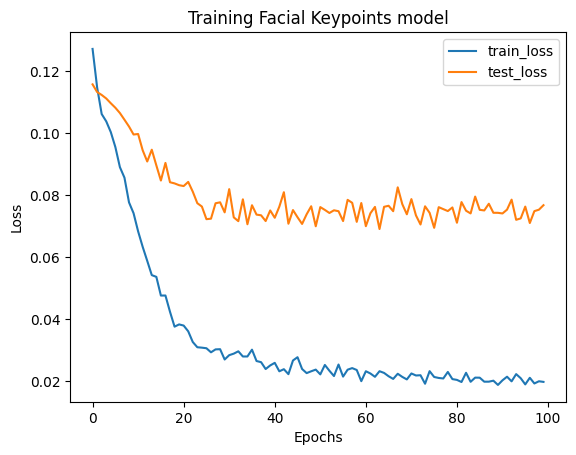

In [355]:
plt.plot(range(epochs), train_epoch, label="train_loss")
plt.plot(range(epochs), val_epoch, label="test_loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Facial Keypoints model")
plt.show()

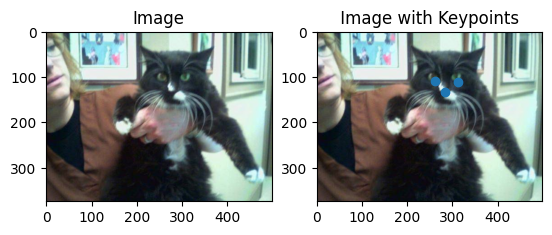

In [362]:
# Displaying the results

index = 9
test_img, points = train_dataset[index]
Facial_key_points = model(test_img[None]).flatten().detach().cpu()
plt.subplot(121)
plt.title("Image")
img = train_dataset.load_img(index)
img = img[:,:,::-1]                                                              
plt.imshow(img)
plt.subplot(122)
plt.title(" Image with Keypoints ")
plt.imshow(img)
x_points = Facial_key_points.numpy()[0::2]
y_points = Facial_key_points.numpy()[1::2]
plt.scatter(x_points*img.shape[1], y_points*img.shape[0])                          # scaling the keypoints with image dimension
plt.show()

In [357]:
print(Facial_key_points)

tensor([0.4330, 0.3645, 0.5176, 0.3522, 0.5066, 0.4103])


In [358]:
x_points = Facial_key_points.numpy()[0::2]
y_points = Facial_key_points.numpy()[1::2]
print(x_points)
print(y_points)

# width = img_arr.shape[0]
# height = img_arr.shape[1]

# plt.scatter(x_points*x_width, y_points*y_height)

[0.4330069  0.5175615  0.50657177]
[0.3645109  0.35224771 0.4103399 ]


In [5]:
for i in range(10):
    
    folder = 'asdsadsd'
    print(folder + str(i).zfill(2)+'.jpg')

asdsadsd00.jpg
asdsadsd01.jpg
asdsadsd02.jpg
asdsadsd03.jpg
asdsadsd04.jpg
asdsadsd05.jpg
asdsadsd06.jpg
asdsadsd07.jpg
asdsadsd08.jpg
asdsadsd09.jpg
